# Imported Libraries

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, LSTM, Input, Reshape 
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import os

# Image Dataset Import

In [2]:
labels = ['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
img_size = 224
def get_data(data_dir):
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                crop_image= img_arr[0:1728,430:2190]
                resized_arr = cv2.resize(crop_image, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
#function call to get_data function that takes file path of the dataset.
data= get_data('dataset/dataset_all_equal_size_image/')

<ipython-input-2-b08f5e223f84>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [4]:
data.shape

(600, 2)

In [5]:
type(data)

numpy.ndarray

# Dividing Data Ndarray into Normal, Cataract, Glaucoma and Retina diseases. 

In [6]:
normal= data[0:300]
normal.shape

(300, 2)

In [7]:
cataract=data[300:400]
cataract.shape

(100, 2)

In [8]:
glaucoma= data[400:500]
glaucoma.shape

(100, 2)

In [9]:
retina_disease= data[500:600]
retina_disease.shape

(100, 2)

In [10]:
random.seed(10)
np.random.shuffle(normal)
np.random.shuffle(cataract)   
np.random.shuffle(glaucoma)
np.random.shuffle(retina_disease)

# Performing Normalization and Resize operation 

In [11]:
def normalize(x_train,x_val,x_test): 
    
    x_train = np.array(x_train) / 255
    x_train.reshape(-1, img_size, img_size, 1)
    
    x_test= np.array(x_test) / 255
    x_test.reshape(-1, img_size, img_size, 1)
    
    
    x_val= np.array(x_val) / 255
    x_val.reshape(-1, img_size, img_size, 1)
    
        
    return (x_train,x_val,x_test) 


# Separating the Images and Labels into Respective Variables

In [12]:
def image_label_split(train,validation,test):
    
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    for feature, label in train:
      x_train.append(feature)
      y_train.append(label)

    for feature, label in validation:
      x_val.append(feature)
      y_val.append(label)


    for feature, label in test:
      x_test.append(feature)
      y_test.append(label)

        
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test= np.array(y_test)
    
    return (x_train,y_train,x_val,y_val,x_test,y_test)


# VGG19-LSTM MODEL

In [13]:
def model_build_compile(k):    
    baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
            layer.trainable = False

    x = baseModel.output

        # LSTM layer
    x = Reshape((49,512))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)
    #     

        # FC layer
    x = Flatten(name="flatten")(x)

        # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
    #    

        # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
    #     

        # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=baseModel.input, outputs=output)
    opt = RMSprop(learning_rate=0.01, clipvalue=100)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    k=k+1
    print("model building and compiling for fold",k)
    
    return model

# Model prediction for Test Images and Computation of Sensitivity and Specificity

In [14]:
def test_pred(x_val,y_val,k):
    predictions = model.predict(x_val)
    predictions = np.argmax(predictions, axis = -1)
    
    print('----------------Test accuracy for',k+1,'fold----------------')
    #Confusion matrix, Accuracy, sensitivity and specificity
    cm1 = confusion_matrix(y_val,predictions)
    print('Confusion Matrix : \n', cm1)


    #####from confusion matrix calculate accuracy
    
    
    sensitivity_1_normal = (cm1[0,0])/(cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (cm1[1,1])/(cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (cm1[2,2])/(cm1[2,0]+cm1[2,1]+cm1[2,2]+cm1[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (cm1[3,3])/(cm1[3,0]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])/(cm1[1,0]+cm1[2,0]+cm1[3,0]+cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])/(cm1[0,1]+cm1[2,1]+cm1[3,1]+cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])/(cm1[0,2]+cm1[1,2]+cm1[3,2]+cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])/(cm1[0,3]+cm1[1,3]+cm1[2,3]+cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(cm1))
    test_accuracy=(cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)
    print('-----------------------------End of',k+1,'Fold--------------------------')
    return test_accuracy,Specificity,Sensitivity,cm1


In [15]:
CM= []
test_accuracy=[]
test_sensitivity=[]
test_specificity=[]
train_acc = []
val_acc = []
train_loss = []
val_loss = []

# VGG19-LSTM 5 Fold Cross Validation

In [16]:
for k in range (5):  # for loop to run 5 folds 
    n_normal=30      # specifying the number of images for normal class in test phase,calulated as per 10% of total normal class images 300.
    n_rest=10        # specifying the number of images for disease classes in test phase,calulated as per 10% of total normal class images 100.
    
    # Adding the images in normal validation set by using k*n_normal to (k+1)*n_normal as index values for normal dataset divided in cell 6.
    test_normal= normal[k*n_normal:(k+1)*n_normal]                              
    print('------------------------Start of',k+1,'Fold------------------------')
    print('test images for normal class from',k*n_normal,(k+1)*n_normal)
    
    # Adding the images in cataract validation set by using k*n_rest to (k+1)*n_rest as index values for cataract dataset divided in cell 7.
    test_cataract= cataract[k*n_rest:(k+1)*n_rest]
    print('test images for cataract class from',k*n_rest,(k+1)*n_rest)
    
    # Adding the images in gluacoma validation set by using k*n_rest to (k+1)*n_rest as index values for gluacoma dataset divided in cell 8.
    test_glaucoma= glaucoma[k*n_rest:(k+1)*n_rest]
    print('test images for glaucoma class from',k*n_rest,(k+1)*n_rest)
    
    # Adding the images in retina disease validation set by using k*n_rest to (k+1)*n_rest as index values for retina disease dataset divided in cell 9.
    test_retina= retina_disease[k*n_rest:(k+1)*n_rest]
    print('test images for retina disease class from',k*n_rest,(k+1)*n_rest)
    
    # Now for train and validation set of Normal images first adding 0 to k*n_normal images and then adding all the images from (k+1)*n_normal till last image. 
    
    train_validation_normal= normal[:k*n_normal] 
    train_validation_normal= np.append(train_validation_normal,normal[(k+1)*n_normal:],axis=0)
    print('train_validation images for normal class from 0 to',k*n_normal,'and',(k+1)*n_normal,'to 300')

    # Now for train and validation set of cataract images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 

    train_validation_cataract= cataract[:k*n_rest] 
    train_validation_cataract= np.append(train_validation_cataract,cataract[(k+1)*n_rest:],axis=0)
    print('train_validation images for cataract class from 0 to',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    # Now for train and validation set of glaucoma images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 
    train_validation_glaucoma= glaucoma[:k*n_rest] 
    train_validation_glaucoma= np.append(train_validation_glaucoma,glaucoma[(k+1)*n_rest:],axis=0)
    print('train_validation  images for glaucoma class from 0',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    # Now for train and validation set of retina disease images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 
    train_validation_retina= retina_disease[:k*n_rest] 
    train_validation_retina= np.append(train_validation_retina,retina_disease[(k+1)*n_rest:],axis=0)
    print('train_validation images for retina disease class from 0 to',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    
    # Splitting the train validation datasets in 80:20 ratio which would eventually give us 70% images in train and 20% images in validation and 10% in test.
    normal_train, normal_validation                 = train_test_split(train_validation_normal, test_size=0.20, random_state=14,shuffle=True)
    cataract_train, cataract_validation             = train_test_split(train_validation_cataract, test_size=0.20, random_state=14,shuffle=True)
    glaucoma_train, glaucoma_validation             = train_test_split(train_validation_glaucoma, test_size=0.20, random_state=14,shuffle=True)
    retina_disease_train, retina_disease_validation = train_test_split(train_validation_retina, test_size=0.20, random_state=14,shuffle=True)

    # Appending all train set images for all classes
    train= np.append(normal_train,cataract_train,axis=0)
    train= np.append(train,glaucoma_train,axis=0)
    train= np.append(train,retina_disease_train,axis=0)

    # Appending all validation set images for all classes
    validation= np.append(normal_validation,cataract_validation,axis=0)
    validation= np.append(validation,glaucoma_validation,axis=0)
    validation= np.append(validation,retina_disease_validation,axis=0)
    
    # Appending all test set images for all classes
    test= np.append(test_normal,test_cataract,axis=0)
    test= np.append(test,test_glaucoma,axis=0)
    test= np.append(test,test_retina,axis=0)    
    
    # Shuffling the train validation and test set as they are added sequentially. 
    random.seed(6)
    np.random.shuffle(train)
    np.random.shuffle(validation)   
    np.random.shuffle(test)
 
    # Passing the train validation test as argument for image_label_split function that return features and labels separated.
    x_train,y_train,x_val,y_val,x_test,y_test = image_label_split(train,validation,test)
    
    # Passing the x_Train x_val and x_test as a argument for normalize function that returns the normalized and reshaped sets.
    x_train,x_val,x_test = normalize(x_train,x_val,x_test)
    
    # model building and model compile is done using a model_build_compile(). 
    
    model = model_build_compile(k)
    history = model.fit(x_train,y_train,epochs =50, validation_data = (x_val,y_val))
    

    train_acc = np.append(train_acc,history.history['accuracy'])
    val_acc = np.append(val_acc,history.history['val_accuracy'])
    
    train_loss = np.append(train_loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
                        
    x,y,z,c = test_pred(x_test,y_test,k)
    

    CM.append([c])
    test_accuracy.append(x)
    test_specificity.append(y)
    test_sensitivity.append(z)

    

------------------------Start of 1 Fold------------------------
test images for normal class from 0 30
test images for cataract class from 0 10
test images for glaucoma class from 0 10
test images for retina disease class from 0 10
train_validation images for normal class from 0 to 0 and 30 to 300
train_validation images for cataract class from 0 to 0 and 10 to 100
train_validation  images for glaucoma class from 0 0 and 10 to 100
train_validation images for retina disease class from 0 to 0 and 10 to 100
model building and compiling for fold 1
Epoch 1/50
14/14 [==============================] - 95s 7s/step - loss: 17.1688 - accuracy: 0.4329 - val_loss: 196.7006 - val_accuracy: 0.1667
Epoch 2/50
14/14 [==============================] - 104s 7s/step - loss: 10.2623 - accuracy: 0.5324 - val_loss: 182.0252 - val_accuracy: 0.1667
Epoch 3/50
14/14 [==============================] - 106s 8s/step - loss: 6.5122 - accuracy: 0.5486 - val_loss: 80.9171 - val_accuracy: 0.1667
Epoch 4/50
14/14 [===

model building and compiling for fold 2
Epoch 1/50
14/14 [==============================] - 131s 9s/step - loss: 22.7639 - accuracy: 0.3542 - val_loss: 73.1095 - val_accuracy: 0.1667
Epoch 2/50
14/14 [==============================] - 130s 9s/step - loss: 8.1997 - accuracy: 0.4931 - val_loss: 62.4114 - val_accuracy: 0.5000
Epoch 3/50
14/14 [==============================] - 129s 9s/step - loss: 7.6824 - accuracy: 0.5278 - val_loss: 40.7816 - val_accuracy: 0.5000
Epoch 4/50
14/14 [==============================] - 130s 9s/step - loss: 6.0112 - accuracy: 0.5370 - val_loss: 72.6413 - val_accuracy: 0.5000
Epoch 5/50
14/14 [==============================] - 130s 9s/step - loss: 3.1000 - accuracy: 0.5764 - val_loss: 29.9370 - val_accuracy: 0.5000
Epoch 6/50
14/14 [==============================] - 129s 9s/step - loss: 2.9786 - accuracy: 0.5764 - val_loss: 106.9048 - val_accuracy: 0.1667
Epoch 7/50
14/14 [==============================] - 129s 9s/step - loss: 2.0087 - accuracy: 0.5949 - val_l

14/14 [==============================] - 129s 9s/step - loss: 9.1986 - accuracy: 0.5255 - val_loss: 29.4180 - val_accuracy: 0.4537
Epoch 3/50
14/14 [==============================] - 130s 9s/step - loss: 7.4582 - accuracy: 0.5324 - val_loss: 88.0118 - val_accuracy: 0.1667
Epoch 4/50
14/14 [==============================] - 129s 9s/step - loss: 4.3997 - accuracy: 0.5694 - val_loss: 90.7220 - val_accuracy: 0.5000
Epoch 5/50
14/14 [==============================] - 130s 9s/step - loss: 4.0392 - accuracy: 0.5162 - val_loss: 68.4370 - val_accuracy: 0.5000
Epoch 6/50
14/14 [==============================] - 131s 9s/step - loss: 2.5803 - accuracy: 0.5602 - val_loss: 69.9856 - val_accuracy: 0.1667
Epoch 7/50
14/14 [==============================] - 129s 9s/step - loss: 1.6130 - accuracy: 0.6111 - val_loss: 155.0898 - val_accuracy: 0.1667
Epoch 8/50
14/14 [==============================] - 129s 9s/step - loss: 1.7526 - accuracy: 0.5856 - val_loss: 45.9068 - val_accuracy: 0.1667
Epoch 9/50
14/14

14/14 [==============================] - 130s 9s/step - loss: 7.2192 - accuracy: 0.5486 - val_loss: 42.8328 - val_accuracy: 0.2222
Epoch 4/50
14/14 [==============================] - 129s 9s/step - loss: 4.5782 - accuracy: 0.5139 - val_loss: 36.5421 - val_accuracy: 0.1019
Epoch 5/50
14/14 [==============================] - 129s 9s/step - loss: 3.4752 - accuracy: 0.5394 - val_loss: 64.9410 - val_accuracy: 0.1667
Epoch 6/50
14/14 [==============================] - 130s 9s/step - loss: 2.2201 - accuracy: 0.5579 - val_loss: 112.9586 - val_accuracy: 0.1667
Epoch 7/50
14/14 [==============================] - 129s 9s/step - loss: 2.1753 - accuracy: 0.5995 - val_loss: 36.8194 - val_accuracy: 0.3056
Epoch 8/50
14/14 [==============================] - 129s 9s/step - loss: 1.8793 - accuracy: 0.5486 - val_loss: 67.7545 - val_accuracy: 0.1667
Epoch 9/50
14/14 [==============================] - 129s 9s/step - loss: 1.3433 - accuracy: 0.6134 - val_loss: 53.6693 - val_accuracy: 0.1667
Epoch 10/50
14/1

14/14 [==============================] - 130s 9s/step - loss: 5.5250 - accuracy: 0.5370 - val_loss: 81.8588 - val_accuracy: 0.1667
Epoch 5/50
14/14 [==============================] - 129s 9s/step - loss: 4.2050 - accuracy: 0.5255 - val_loss: 45.8915 - val_accuracy: 0.1667
Epoch 6/50
14/14 [==============================] - 130s 9s/step - loss: 2.5114 - accuracy: 0.5741 - val_loss: 46.3477 - val_accuracy: 0.1667
Epoch 7/50
14/14 [==============================] - 129s 9s/step - loss: 1.6744 - accuracy: 0.5463 - val_loss: 55.2291 - val_accuracy: 0.1667
Epoch 8/50
14/14 [==============================] - 130s 9s/step - loss: 1.3771 - accuracy: 0.6204 - val_loss: 64.9893 - val_accuracy: 0.1667
Epoch 9/50
14/14 [==============================] - 129s 9s/step - loss: 1.1414 - accuracy: 0.6574 - val_loss: 28.9510 - val_accuracy: 0.1667
Epoch 10/50
14/14 [==============================] - 129s 9s/step - loss: 1.5625 - accuracy: 0.5718 - val_loss: 75.2214 - val_accuracy: 0.1667
Epoch 11/50
14/1

# Test Evaluation Results

In [17]:
test_accuracy

[0.4, 0.6166666666666667, 0.5833333333333334, 0.55, 0.5166666666666667]

In [18]:
mean_test_accuracy=np.mean(test_accuracy)
mean_test_accuracy

0.5333333333333334

In [19]:
test_sensitivity

[0.30000000000000004,
 0.5083333333333333,
 0.5916666666666667,
 0.4916666666666666,
 0.5916666666666667]

In [20]:
mean_test_sensitivity= np.mean(test_sensitivity)
mean_test_sensitivity

0.4966666666666667

In [21]:
test_specificity

[0.7006302521008404,
 0.8098473708229805,
 0.8294745484400656,
 0.7834701420890937,
 0.82546768707483]

In [22]:
mean_test_specificity= np.mean(test_specificity)
mean_test_specificity

0.7897780001055621

# Training and Validation Evaluation Results

In [23]:
train_acc

array([0.43287036, 0.5324074 , 0.5486111 , 0.5462963 , 0.55787039,
       0.56712961, 0.62037039, 0.65046299, 0.61805558, 0.6574074 ,
       0.6550926 , 0.7037037 , 0.6875    , 0.7175926 , 0.73148149,
       0.76157409, 0.76851851, 0.79166669, 0.8263889 , 0.78703701,
       0.78472221, 0.88425928, 0.7986111 , 0.81481481, 0.86342591,
       0.8888889 , 0.83796299, 0.8587963 , 0.8425926 , 0.89351851,
       0.93518519, 0.9074074 , 0.88657409, 0.87731481, 0.9236111 ,
       0.92592591, 0.87962961, 0.91666669, 0.94444442, 0.9212963 ,
       0.9375    , 0.9212963 , 0.94212961, 0.94907409, 0.91435188,
       0.93981481, 0.9537037 , 0.94675928, 0.9699074 , 0.92592591,
       0.35416666, 0.49305555, 0.52777779, 0.53703701, 0.5763889 ,
       0.5763889 , 0.5949074 , 0.61342591, 0.60648149, 0.66435188,
       0.66666669, 0.67592591, 0.7013889 , 0.72222221, 0.73842591,
       0.74074072, 0.73148149, 0.83101851, 0.83101851, 0.80555558,
       0.84027779, 0.8125    , 0.82175928, 0.88657409, 0.87037

In [24]:
mean_train_accuracy=np.mean(train_acc)
mean_train_accuracy

0.8081111098527909

In [25]:
val_acc

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.2037037 , 0.2037037 ,
       0.16666667, 0.16666667, 0.16666667, 0.23148148, 0.21296297,
       0.2037037 , 0.16666667, 0.22222222, 0.18518518, 0.21296297,
       0.22222222, 0.30555555, 0.44444445, 0.5462963 , 0.44444445,
       0.16666667, 0.5       , 0.5       , 0.5       , 0.5       ,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.5       , 0.16666667, 0.5       , 0.25      , 0.49074075,
       0.48148149, 0.3611111 , 0.5       , 0.35185185, 0.43518519,
       0.25925925, 0.25      , 0.16666667, 0.16666667, 0.16666

In [26]:
mean_val_accuracy=np.mean(val_acc)
mean_val_accuracy

0.24918518805503845

In [27]:
train_loss

array([17.16884613, 10.26230907,  6.51222944,  4.81271744,  3.09632754,
        2.4621551 ,  1.9442625 ,  1.43246734,  1.90623188,  1.27773678,
        1.07394147,  0.87130767,  1.04937458,  1.09441841,  1.07344973,
        0.8890729 ,  0.71756178,  0.61275244,  0.56879395,  0.71044892,
        0.61590344,  0.31707865,  0.65379256,  0.55595618,  0.55217272,
        0.33930972,  0.44880334,  0.38256741,  0.43406156,  0.31948191,
        0.21025078,  0.29787585,  0.390434  ,  0.3696712 ,  0.18193397,
        0.25177252,  0.46901476,  0.24745643,  0.15675326,  0.27219316,
        0.18059446,  0.26041675,  0.1508359 ,  0.14051768,  0.23576857,
        0.23207729,  0.14787097,  0.22228053,  0.10054346,  0.22472632,
       22.76387596,  8.1996994 ,  7.68244505,  6.01120377,  3.09999633,
        2.97862554,  2.00866818,  1.59761965,  1.52111614,  0.8961941 ,
        0.92433751,  1.01203024,  0.94809061,  0.82211614,  1.05137146,
        0.73955929,  0.67535377,  0.51757038,  0.51620591,  0.55

In [28]:
mean_train_loss=np.mean(train_loss)
mean_train_loss

1.4102391167730093

In [29]:
val_loss

array([196.7006073 , 182.025177  ,  80.91713715,  89.64961243,
        92.58319855, 126.0164566 ,  95.89859772,  60.46477127,
        45.07113647,  34.65521622,  23.9937706 ,  28.15537453,
        30.53067589,  41.38500214,  48.4694519 ,  42.02339554,
        74.61327362,  47.94384766,  38.3707428 ,  33.02332306,
        29.16703224,  20.95206642,  21.17567635,  29.30384254,
        28.30862617,   7.73365974,  25.29241943, 291.1322937 ,
        20.81303596,  24.30821419,  26.85552597,  32.61240005,
        27.59710693,  15.74124813,  16.87287521,  17.85619354,
        13.64843845,  19.74687576,   8.97575283,  18.1675396 ,
         5.34323311,  23.0668602 ,  17.0223217 ,  16.54026222,
        10.8756361 ,   9.76104546,   8.79319191,   5.41357422,
         4.84164858,   4.85939884,  73.10952759,  62.4114418 ,
        40.78161621,  72.64131165,  29.93701553, 106.9048233 ,
        85.55125427,  44.14822388,  71.54429626,  53.12083435,
        24.70445251,  30.83588791,  20.37410927,  18.32

In [30]:
mean_val_loss=np.mean(val_loss)
mean_val_loss

30.984921466350556

# Plot to Visualize the Number of Images in Each Label of Trainig Dataset

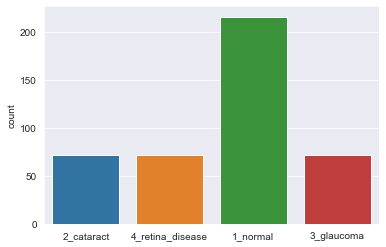

In [31]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Test Dataset.

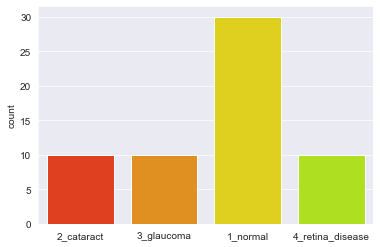

In [32]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l,palette='prism')

# Plot to Visualize the Number of Images in Each Label of Validation Dataset.

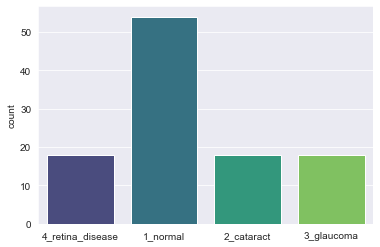

In [33]:
l = []
for i in validation:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l,palette='viridis')

# Training,Validation Accuracy and Loss Plot for 50 Epochs

In [34]:
def plot_print(i,j):
    epochs_range = range(50)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_acc[i:j], label='Training Accuracy')
    plt.plot(epochs_range, val_acc[i:j], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_loss[i:j], label='Training Loss')
    plt.plot(epochs_range, val_loss[i:j], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    return plt.show()

Plot for  1 cross validation accuracy and loss for Training and Validation phase


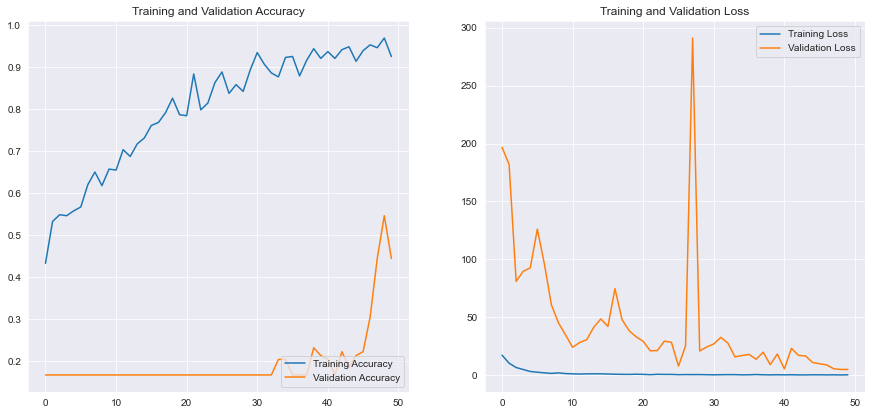

Plot for  2 cross validation accuracy and loss for Training and Validation phase


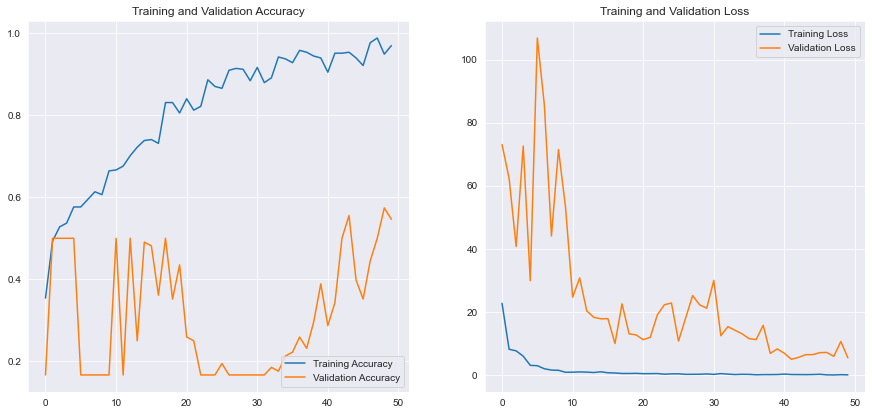

Plot for  3 cross validation accuracy and loss for Training and Validation phase


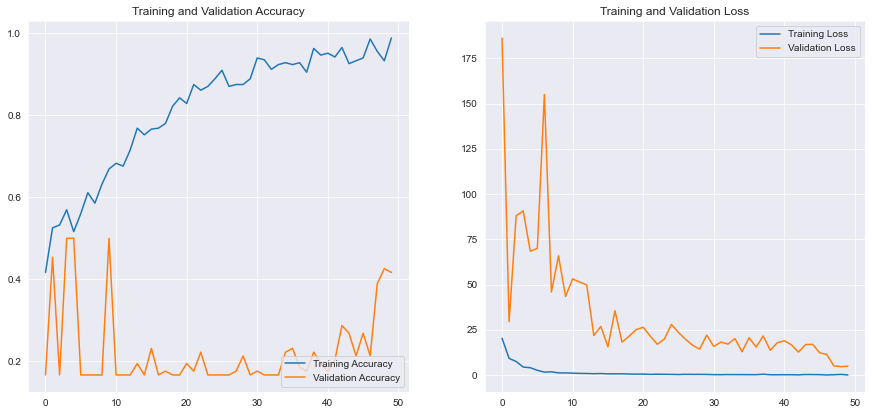

Plot for  4 cross validation accuracy and loss for Training and Validation phase


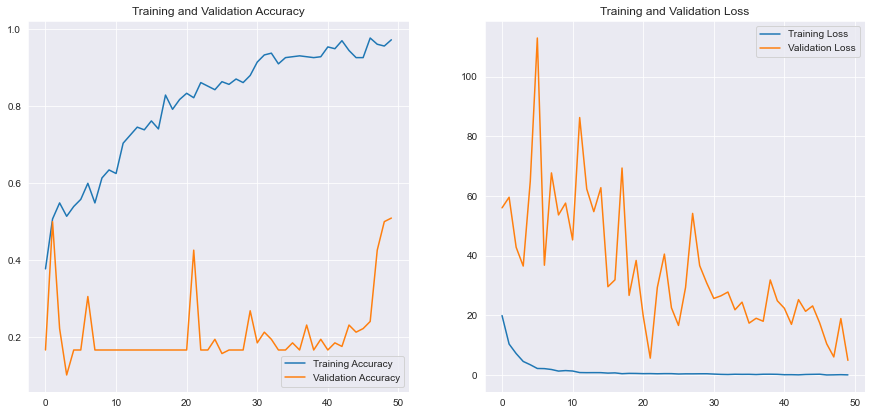

Plot for  5 cross validation accuracy and loss for Training and Validation phase


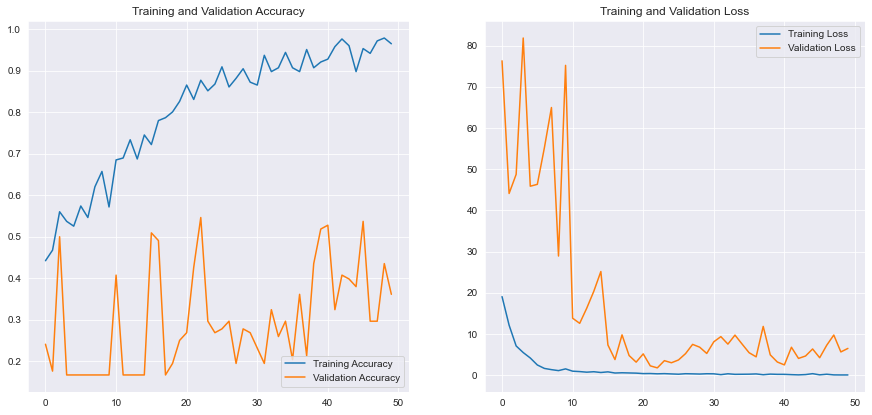

In [35]:
k=1
j=0
for i in range(0,250,50):
    j +=50
    print('Plot for ',k,'cross validation accuracy and loss for Training and Validation phase')
    k +=1
    plot_print(i,j)


# Visualizing Confusion Matrix for Each Fold

In [36]:
CM= np.array(CM)
CM.resize(5,4,4)

In [37]:
def confusionmatrix_vis(i):

        yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        plt.figure(figsize=(8, 8))
        hm =sns.heatmap(CM[i], annot=True,annot_kws={"size": 20}, cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

        hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
        hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

        plt.ylabel("Actual", fontsize = 18)
        plt.xlabel("Predicted",fontsize = 18)
      
        return plt.show()

Confusion Matrix for  1 Cross Validation Test phase


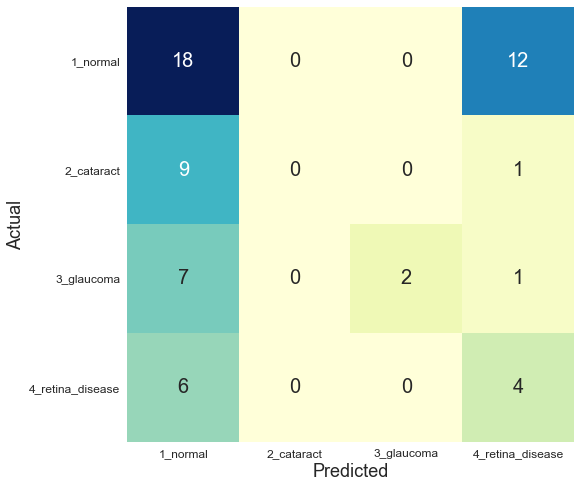

Confusion Matrix for  2 Cross Validation Test phase


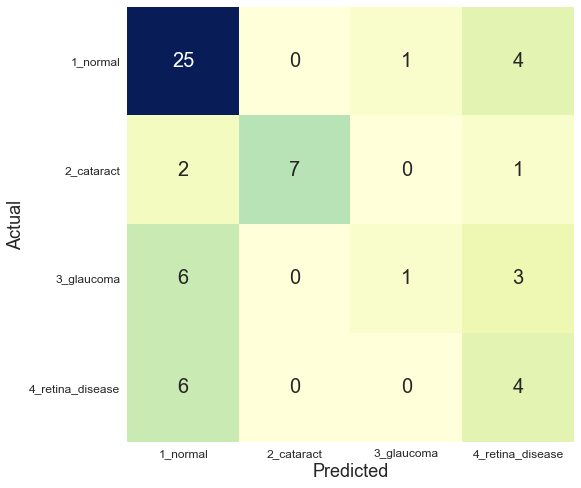

Confusion Matrix for  3 Cross Validation Test phase


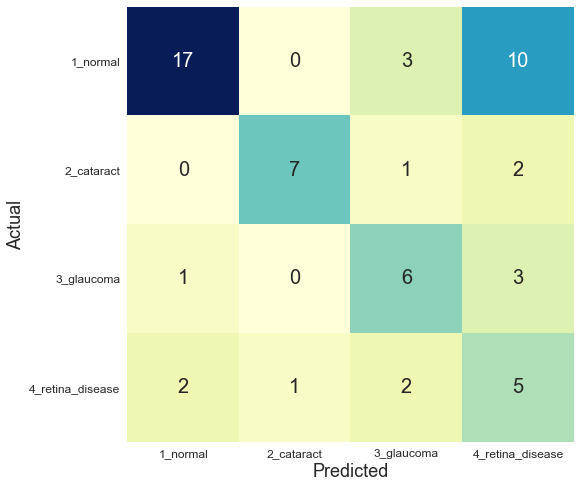

Confusion Matrix for  4 Cross Validation Test phase


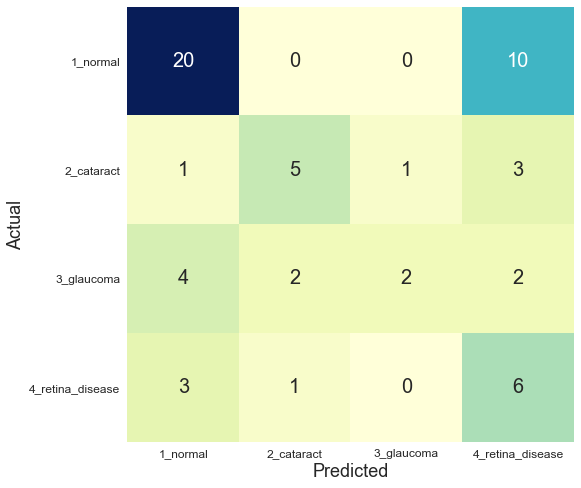

Confusion Matrix for  5 Cross Validation Test phase


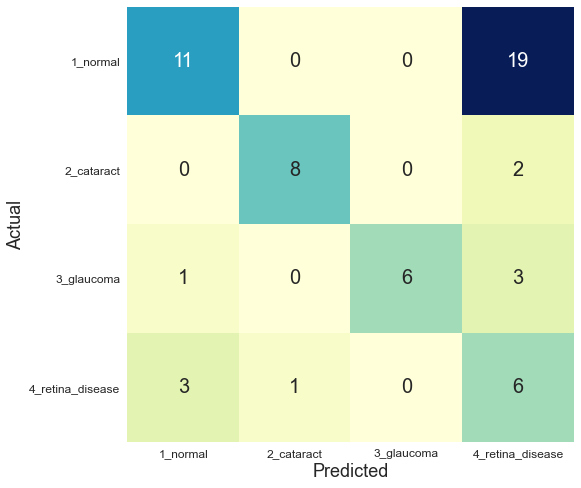

In [38]:
k=1
for i in range(5):    
    print('Confusion Matrix for ',k,'Cross Validation Test phase')
    k +=1
    confusionmatrix_vis(i)
    


# Visualizing Summarized Confusion Matrix of all 5 folds

In [39]:
CM_sum = CM[0]+CM[1]+CM[2]+CM[3]+CM[4]
CM_sum

array([[91,  0,  4, 55],
       [12, 27,  2,  9],
       [19,  2, 17, 12],
       [20,  3,  2, 25]], dtype=int64)

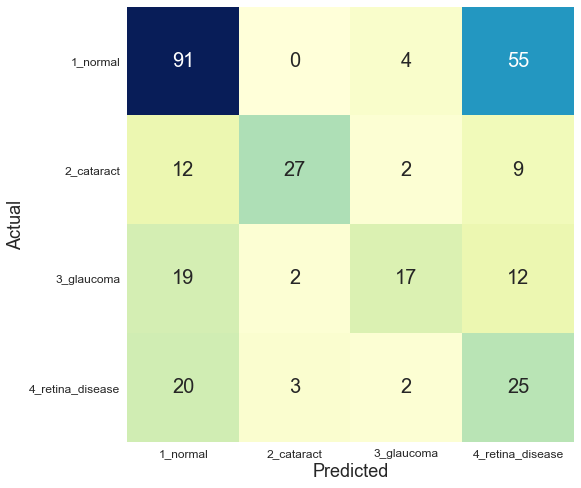

In [40]:
yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
plt.figure(figsize=(8, 8))
hm =sns.heatmap(CM_sum, annot=True,annot_kws={"size": 20},fmt='g', cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

plt.ylabel("Actual", fontsize = 18)
plt.xlabel("Predicted",fontsize = 18)
      
plt.show()

# Reconfirming the values of Accuracy,Sensitivity and Specificity

In [41]:
    sensitivity_1_normal = (CM_sum[0,0])/(CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (CM_sum[1,1])/(CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (CM_sum[2,2])/(CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (CM_sum[3,3])/(CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[1,0]+CM_sum[2,0]+CM_sum[3,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[0,1]+CM_sum[2,1]+CM_sum[3,1]+CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])/(CM_sum[0,2]+CM_sum[1,2]+CM_sum[3,2]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])/(CM_sum[0,3]+CM_sum[1,3]+CM_sum[2,3]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(CM_sum))
    test_accuracy=(CM_sum[0,0]+CM_sum[1,1]+CM_sum[2,2]+CM_sum[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)

    

Accuracy    :  0.5333333333333333
Specificity :  0.7813996025079956
Sensitivity :  0.4966666666666667


# Model Summary

In [42]:
model_build_compile(k)

model building and compiling for fold 7


In [43]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   